In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

dv = 0.001

klin =0

nband = 80

ng =7

ng_adju = (/ 2 /) 

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 1000

nv = 1000

option_compute_btable = 1

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 10 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 540

data w_diffuse
     &     /1.9 , 1.7 , 1.4 , 1.4,
     &     1.4 , 1.55 , 1.6/

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.5,
     &     0.5 , 0.5 , 0.5/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

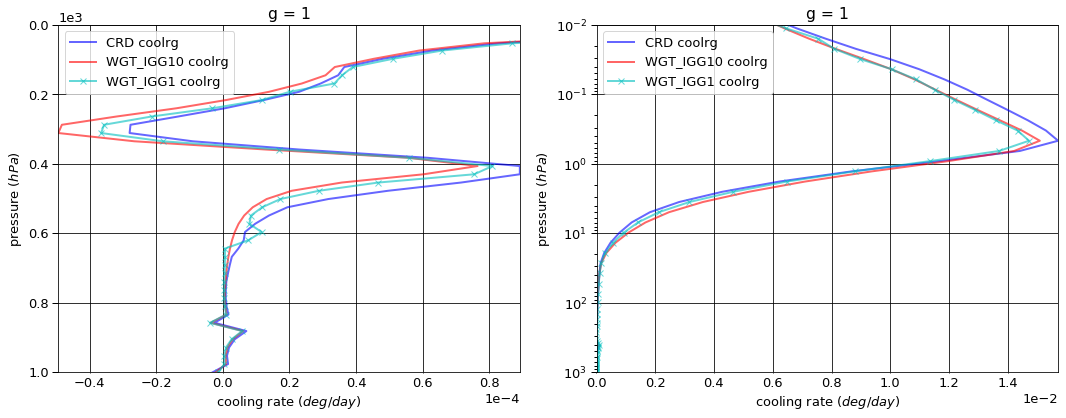

# Figure: cooling rate g-group 2

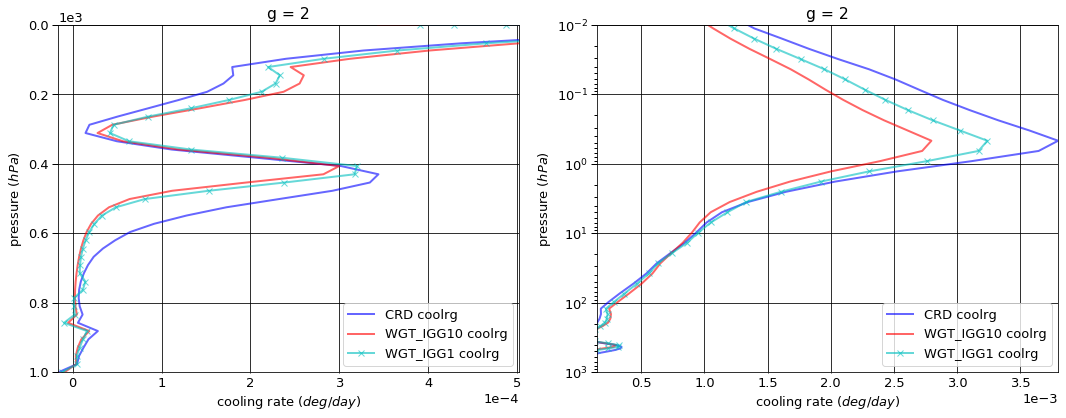

# Figure: cooling rate g-group 3

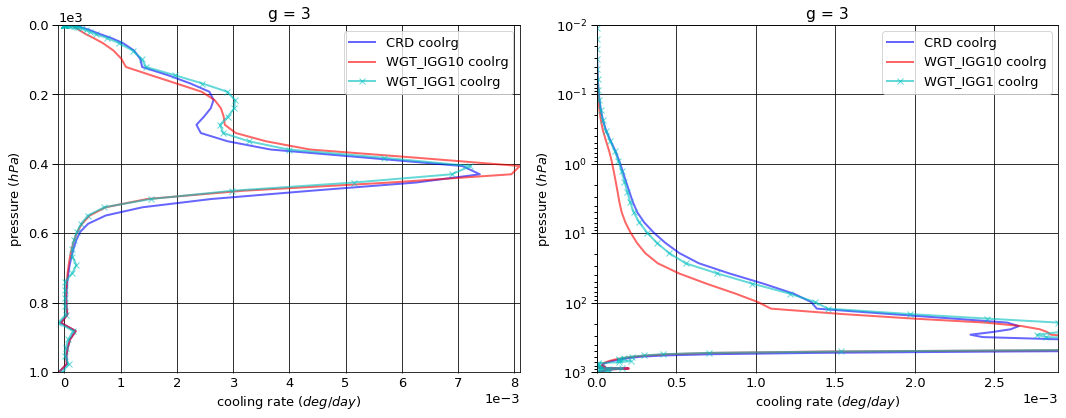

# Figure: cooling rate g-group 4

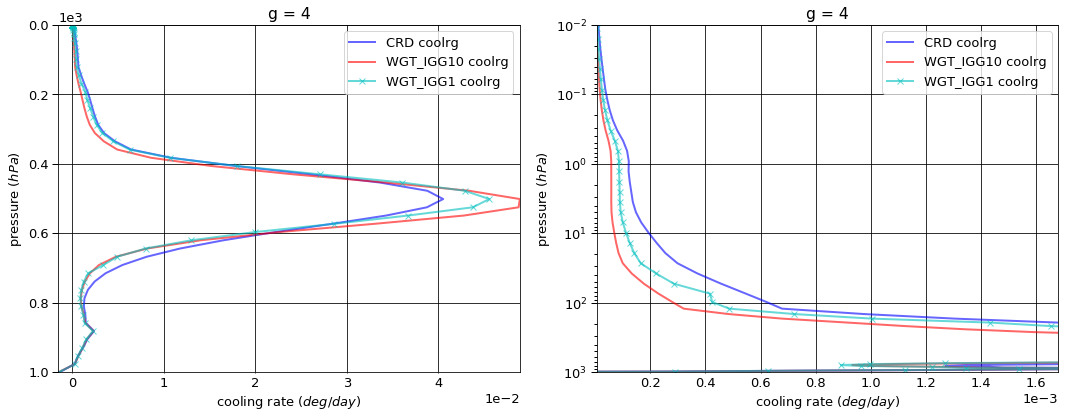

# Figure: cooling rate g-group 5

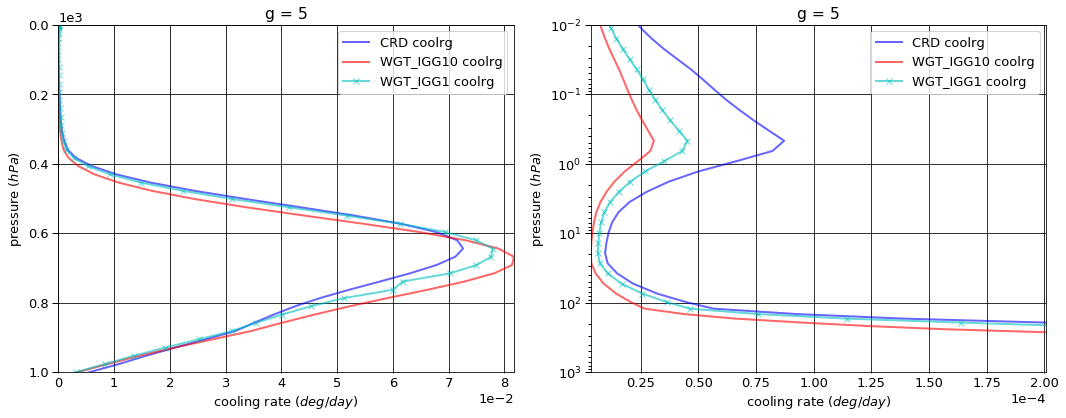

# Figure: cooling rate g-group 6

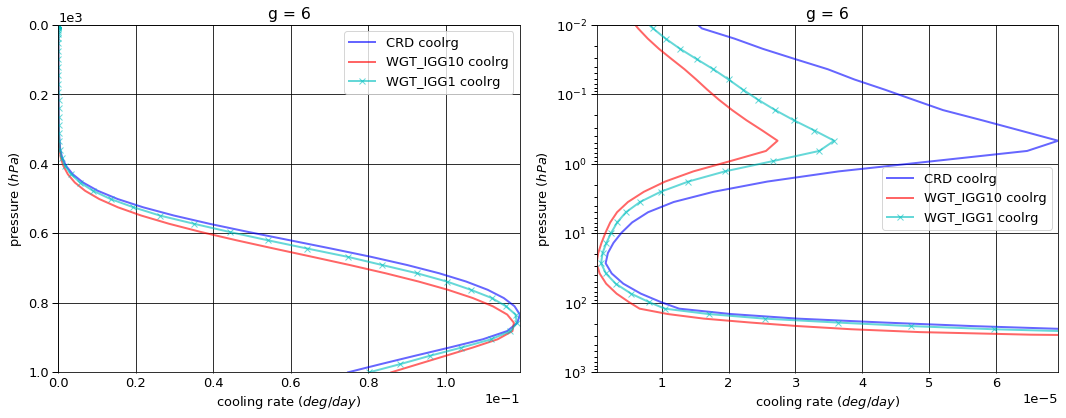

# Figure: cooling rate g-group 7

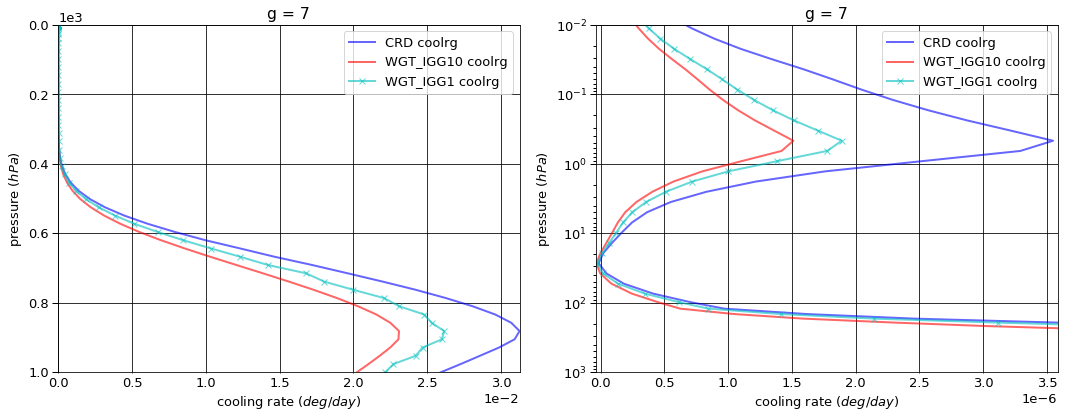

# Figure: cooling rate g-group total

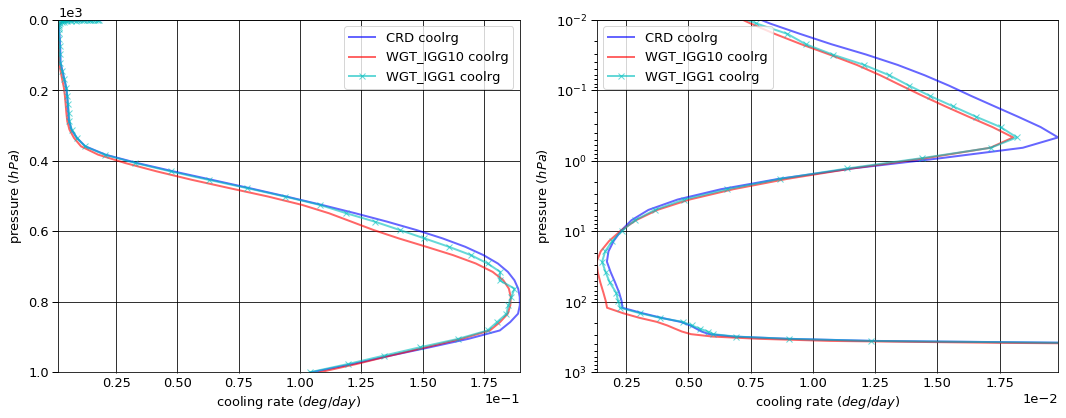

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.007253  0.000000  -0.007253
  1013.0   76     -0.011542  0.011554   0.000012
2 0.0      1      -0.016828  0.000000  -0.016828
  1013.0   76     -0.028720  0.028792   0.000073
3 0.0      1      -0.192994  0.000000  -0.192994
  1013.0   76     -0.316713  0.317083   0.000369
4 0.0      1      -1.069674  0.000000  -1.069674
  1013.0   76     -1.433362  1.439994   0.006632
5 0.0      1      -3.071221  0.000000  -3.071221
  1013.0   76     -3.420637  3.323362  -0.097274
6 0.0      1     -10.555377  0.000000 -10.555377
  1013.0   76    -10.765637  5.397345  -5.368291
7 0.0      1      -7.584683  0.000000  -7.584683
  1013.0   76     -7.614527  1.255968  -6.358560


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.007171  0.000000  -0.007171
  1013.0   76     -0.011542  0.011550   0.000008
2 0.0      1      -0.015850  0.000000  -0.015850
  1013.0   76     -0.028720  0.028753   0.000034
3 0.0      1      -0.190541  0.000000  -0.190541
  1013.0   76     -0.316713  0.317063   0.000350
4 0.0      1      -1.078404  0.000000  -1.078404
  1013.0   76     -1.433362  1.439844   0.006483
5 0.0      1      -3.113800  0.000000  -3.113800
  1013.0   76     -3.420637  3.414701  -0.005936
6 0.0      1     -10.616168  0.000000 -10.616168
  1013.0   76    -10.765637  4.988786  -5.776851
7 0.0      1      -7.593907  0.000000  -7.593907
  1013.0   76     -7.614527  0.917079  -6.697449


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.007152  0.000000  -0.007152
  1013.0   76     -0.011542  0.011547   0.000005
2 0.0      1      -0.016045  0.000000  -0.016045
  1013.0   76     -0.028720  0.028764   0.000044
3 0.0      1      -0.188484  0.000000  -0.188484
  1013.0   76     -0.316713  0.317034   0.000321
4 0.0      1      -1.061730  0.000000  -1.061730
  1013.0   76     -1.433362  1.439597   0.006235
5 0.0      1      -3.072855  0.000000  -3.072855
  1013.0   76     -3.420637  3.402461  -0.018176
6 0.0      1     -10.578846  0.000000 -10.578846
  1013.0   76    -10.765637  5.246397  -5.519240
7 0.0      1      -7.588515  0.000000  -7.588515
  1013.0   76     -7.614527  1.052523  -6.562005


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      8.180170e-05  0.000000  0.000082
  1013.0   76     0.000000e+00 -0.000004 -0.000004
2 0.0      1      9.778330e-04  0.000000  0.000978
  1013.0   76     0.000000e+00 -0.000039 -0.000039
3 0.0      1      2.452640e-03  0.000000  0.002453
  1013.0   76     0.000000e+00 -0.000019 -0.000019
4 0.0      1     -8.730200e-03  0.000000 -0.008730
  1013.0   76     0.000000e+00 -0.000150 -0.000150
5 0.0      1     -4.257970e-02  0.000000 -0.042580
  1013.0   76     0.000000e+00  0.091338  0.091338
6 0.0      1     -6.079100e-02  0.000000 -0.060791
  1013.0   76     0.000000e+00 -0.408560 -0.408560
7 0.0      1     -9.224200e-03  0.000000 -0.009224
  1013.0   76     8.881784e-16 -0.338889 -0.338889


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.012427e-04  0.000000  0.000101
  1013.0   76     0.000000e+00 -0.000007 -0.000007
2 0.0      1      7.826020e-04  0.000000  0.000783
  1013.0   76     0.000000e+00 -0.000029 -0.000029
3 0.0      1      4.510400e-03  0.000000  0.004510
  1013.0   76     0.000000e+00 -0.000049 -0.000049
4 0.0      1      7.944200e-03  0.000000  0.007944
  1013.0   76     0.000000e+00 -0.000397 -0.000397
5 0.0      1     -1.634500e-03  0.000000 -0.001634
  1013.0   76     0.000000e+00  0.079098  0.079098
6 0.0      1     -2.346900e-02  0.000000 -0.023469
  1013.0   76     0.000000e+00 -0.150948 -0.150949
7 0.0      1     -3.832000e-03  0.000000 -0.003832
  1013.0   76     8.881784e-16 -0.203445 -0.203445

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.605518e-03
  1001.112500 75    -3.093433e-06
2 0.000312    1      3.936071e-04
  1001.112500 75    -1.613585e-05
3 0.000312    1      1.126177e-08
  1001.112500 75    -9.814924e-05
4 0.000312    1      1.998090e-06
  1001.112500 75    -1.404180e-03
5 0.000312    1      3.898500e-06
  1001.112500 75     5.505139e-03
6 0.000312    1      5.675293e-07
  1001.112500 75     7.477993e-02
7 0.000312    1     -3.070484e-08
  1001.112500 75     2.591391e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.829067e-03
  1001.112500 75    -2.124066e-06
2 0.000312    1      3.438833e-04
  1001.112500 75    -9.309505e-06
3 0.000312    1      7.647316e-09
  1001.112500 75    -9.714032e-05
4 0.000312    1      7.565346e-07
  1001.112500 75    -1.517965e-03
5 0.000312    1      5.686821e-07
  1001.112500 75     3.374277e-03
6 0.000312    1     -9.616128e-08
  1001.112500 75     8.593432e-02
7 0.000312    1     -1.517830e-08
  1001.112500 75     2.022590e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.657933e-03
  1001.112500 75    -1.464174e-06
2 0.000312    1      3.912156e-04
  1001.112500 75    -1.216340e-05
3 0.000312    1      1.156235e-08
  1001.112500 75    -4.015776e-05
4 0.000312    1      1.297631e-06
  1001.112500 75    -1.464751e-03
5 0.000312    1      1.281702e-06
  1001.112500 75     3.104753e-03
6 0.000312    1      1.044949e-07
  1001.112500 75     8.024492e-02
7 0.000312    1     -1.579072e-08
  1001.112500 75     2.215264e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.235496e-04
  1001.112500 75     9.693663e-07
2 0.000312    1     -4.972379e-05
  1001.112500 75     6.826342e-06
3 0.000312    1     -3.614454e-09
  1001.112500 75     1.008919e-06
4 0.000312    1     -1.241556e-06
  1001.112500 75    -1.137848e-04
5 0.000312    1     -3.329818e-06
  1001.112500 75    -2.130861e-03
6 0.000312    1     -6.636905e-07
  1001.112500 75     1.115439e-02
7 0.000312    1      1.552654e-08
  1001.112500 75    -5.688007e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      5.241530e-05
  1001.112500 75     1.629259e-06
2 0.000312    1     -2.391560e-06
  1001.112500 75     3.972446e-06
3 0.000312    1      3.005790e-10
  1001.112500 75     5.799148e-05
4 0.000312    1     -7.004595e-07
  1001.112500 75    -6.057040e-05
5 0.000312    1     -2.616798e-06
  1001.112500 75    -2.400386e-03
6 0.000312    1     -4.630343e-07
  1001.112500 75     5.464993e-03
7 0.000312    1      1.491413e-08
  1001.112500 75    -3.761268e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.498029,0.000000,-22.498029
1013.0,76,-23.591138,11.774099,-11.817039



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.615842,0.000000,-22.615842
1013.0,76,-23.591138,11.117776,-12.473362



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.513626,0.000000,-22.513626
1013.0,76,-23.591138,11.498323,-12.092815



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.117813,0.000000,-0.117813
1013.0,76,0.000000,-0.656323,-0.656323



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.015597,0.000000,-0.015597
1013.0,76,0.000000,-0.275776,-0.275776


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.002006
1001.112500,75,0.104677



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.002174
1001.112500,75,0.107908



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.002052
1001.112500,75,0.103984



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000169
1001.112500,75,0.003231



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000046
1001.112500,75,-0.000694


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000487,0.000490
2,0.001213,0.001218
3,0.013375,0.013435
4,0.060525,0.060808
5,0.144325,0.145143
6,0.455137,0.456604
7,0.324937,0.322302


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.541951e-19
2,2.122874e-20
3,4.182942e-21
4,5.437189e-22
5,7.067520e-23
6,9.186702e-24
7,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.541951e-19,NaN,0.000487,0.000490,0.000487,0.000490,10.0
2,2.122874e-20,0.137674,0.001213,0.001218,0.001700,0.001708,10.0
3,4.182942e-21,0.197041,0.013375,0.013435,0.015075,0.015143,600.0
4,5.437189e-22,0.129985,0.060525,0.060808,0.075600,0.075951,600.0
5,7.067520e-23,0.129985,0.144325,0.145143,0.219925,0.221094,600.0
6,9.186702e-24,0.129985,0.455137,0.456604,0.675063,0.677698,600.0
7,1.194132e-24,0.129985,0.324937,0.322302,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
